<a href="https://colab.research.google.com/github/aksanaboo/sephora/blob/main/SephoraRecommenderSystemPart2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [3]:
#datasets
product = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/product_info.csv')
review_1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/reviews_0-250.csv')
review_2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/reviews_250-500.csv')
review_3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/reviews_500-750.csv')
review_4 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/reviews_750-1250.csv')
review_5 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/reviews_1250-end.csv')

<ipython-input-3-e4867818210a>:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  review_1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/reviews_0-250.csv')
<ipython-input-3-e4867818210a>:6: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  review_4 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/reviews_750-1250.csv')
<ipython-input-3-e4867818210a>:7: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  review_5 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/reviews_1250-end.csv')


In [4]:
df = [review_1,review_2,review_3,review_4,review_5]
review = pd.concat(df,axis=0)

In [5]:
sephora_data = review[['author_id','product_id','product_name','rating','submission_time']]

In [6]:
sephora_data.head()

,author_id,product_id,product_name,rating,submission_time
0,1741593524,P504322,Gentle Hydra-Gel Face Cleanser,5,2023-02-01
1,31423088263,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,1,2023-03-21
2,5061282401,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,5,2023-03-21
3,6083038851,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,5,2023-03-20
4,47056667835,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,5,2023-03-20


In [7]:
sephora_data.isnull().sum()

author_id          0
product_id         0
product_name       0
rating             0
submission_time    0
dtype: int64

In [8]:
sephora_data.duplicated().sum()

960

In [9]:
#Drop duplicates
sephora_data.drop_duplicates(inplace=True)

<ipython-input-9-cd39b414e6f7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sephora_data.drop_duplicates(inplace=True)


In [10]:
sephora_data.shape

(1093451, 5)

In [11]:
#Number of unique users
print('This dataset has', sephora_data['author_id'].nunique(), 'unique users')

#Number of unique products
print('This dataset has', sephora_data['product_id'].nunique(), 'unique products')

#Number of unique ratings
print('This dataset has', sephora_data['rating'].nunique(), 'unique ratings')

#List of rating
print('Ratings are', sorted(sephora_data['rating'].unique()))

This dataset has 578653 unique users
This dataset has 2351 unique products
This dataset has 5 unique ratings
Ratings are [1, 2, 3, 4, 5]


In [12]:
df =  sephora_data['product_id'].value_counts().reset_index()

In [13]:
df.rename(columns={'index':'product_id','product_id':'rating count'})

,product_id,rating count
0,P420652,16095
1,P7880,8729
2,P218700,7755
3,P248407,7529
4,P269122,7411
...,...,...
2346,P501153,1
2347,P504424,1
2348,P480445,1
2349,P501886,1


In [14]:
#Agg by product
agg_rating = sephora_data.groupby('product_name').agg(mean_rating = ('rating','mean'), number_of_ratings = ('rating','count')).reset_index()

In [15]:
agg_rating.head()

,product_name,mean_rating,number_of_ratings
0,"""B"" Oil",4.228571,245
1,"""Buffet"" + Copper Peptides 1%",4.180392,255
2,(Glow)Setting 100% Mineral Powder SPF 35,4.482993,147
3,(Re) Setting Refreshing Mist SPF 40,3.643979,382
4,(Re)setting 100% Mineral Powder Sunscreen SPF ...,4.037135,377


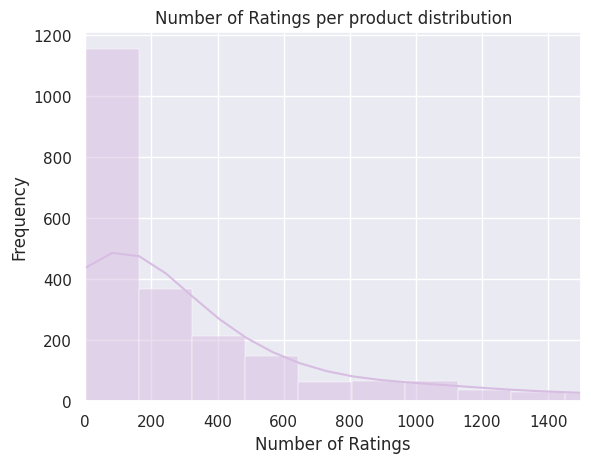

In [16]:
#number_of_ratings distribution
sns.set(style='darkgrid')
sns.histplot(data=agg_rating,x='number_of_ratings',kde=True,bins=100,color='#D7BDE2')
plt.xlabel('Number of Ratings')
plt.ylabel ('Frequency')
plt.xlim(0,1500)
plt.title('Number of Ratings per product distribution')
plt.show()

In [17]:
agg_rating['number_of_ratings'].describe()

count     2334.000000
mean       468.488003
std        892.038093
min          1.000000
25%         37.000000
50%        166.000000
75%        489.750000
max      16095.000000
Name: number_of_ratings, dtype: float64

In [18]:
#Keep products that have over 4000 number_of_ratings
rating_4000 = agg_rating['number_of_ratings'] > 4000
agg_rating_4000 = agg_rating[rating_4000]

In [19]:
agg_rating_4000.head()

,product_name,mean_rating,number_of_ratings
18,100 percent Pure Argan Oil,4.499678,7755
159,Alpha Beta Extra Strength Daily Peel Pads,4.545001,7411
415,Cicapair Tiger Grass Color Correcting Treatmen...,3.989660,5319
484,Clear Improvement Active Charcoal Mask to Clea...,4.328912,4524
569,Daily Microfoliant Exfoliator,4.695605,4596


In [20]:
agg_rating_4000.shape

(29, 3)

In [21]:
#most popular products and their ratings
agg_rating_4000.sort_values(by='number_of_ratings',ascending=False,inplace=True)

<ipython-input-21-40a5b269b979>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_rating_4000.sort_values(by='number_of_ratings',ascending=False,inplace=True)


In [22]:
agg_rating_4000.head()

,product_name,mean_rating,number_of_ratings
1131,Lip Sleeping Mask Intense Hydration with Vitam...,4.350047,16095
1876,Soy Hydrating Gentle Face Cleanser,4.362814,8729
18,100 percent Pure Argan Oil,4.499678,7755
2163,Ultra Repair Cream Intense Hydration,4.517599,7529
159,Alpha Beta Extra Strength Daily Peel Pads,4.545001,7411


<Figure size 1000x800 with 0 Axes>

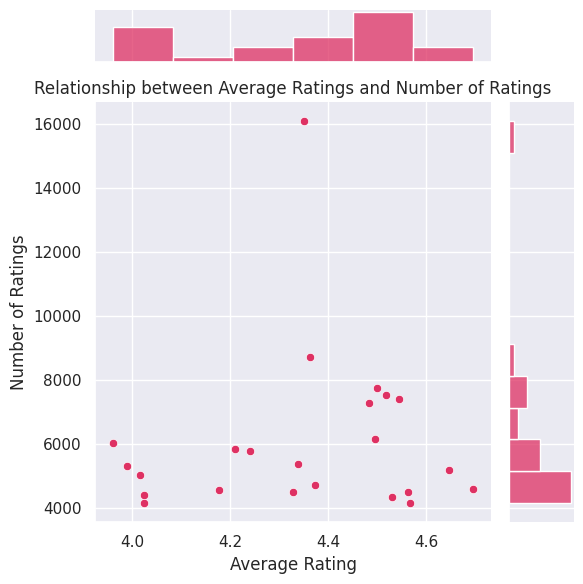

In [23]:
#relationship between mean_rating and number_of_ratings
plt.figure(figsize=(10,8))
sns.set(style='darkgrid')
sns.jointplot(data=agg_rating_4000, x='mean_rating',y='number_of_ratings',color='#DE3163')
plt.xlabel('Average Rating')
plt.ylabel('Number of Ratings')
plt.title('Relationship between Average Ratings and Number of Ratings')
plt.tight_layout()
plt.show()

In [24]:
fig = px.scatter(agg_rating_4000, x='mean_rating', y='number_of_ratings',color='product_name',title='Relationship between Average Rating and Ratings Count')
fig.update_layout(
    xaxis_title='Average Rating',
    yaxis_title='Ratings count',
    showlegend=False,
    title_x=0.5
)
fig.show()

In [25]:
#merge data
df_4000 = pd.merge(sephora_data,agg_rating_4000[['product_name']],on='product_name',how='inner')

In [26]:
df_4000.head()

,author_id,product_id,product_name,rating,submission_time
0,31423088263,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,1,2023-03-21
1,5061282401,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,5,2023-03-21
2,6083038851,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,5,2023-03-20
3,47056667835,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,5,2023-03-20
4,42802569154,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,4,2023-03-19


In [27]:
df_4000.product_name.nunique()

29

In [28]:
df_4000.author_id.nunique()

123135

## Creating a User-Product matrix

In [29]:
matrix = df_4000.pivot_table(index='author_id', columns='product_name', values='rating')
matrix.head()

product_name,100 percent Pure Argan Oil,Alpha Beta Extra Strength Daily Peel Pads,Cicapair Tiger Grass Color Correcting Treatment SPF 30,Clear Improvement Active Charcoal Mask to Clear Pores,Daily Microfoliant Exfoliator,Good Genes All-In-One AHA Lactic Acid Treatment,Greek Yoghurt Foaming Cream Cleanser,Green Clean Makeup Meltaway Cleansing Balm Limited Edition Jumbo,Green Clean Makeup Removing Cleansing Balm,Jet Lag Mask,...,Pure Skin Face Cleanser,Rosebud Salve,Salicylic Acid Acne Healing Dots,Soy Hydrating Gentle Face Cleanser,Superfood Antioxidant Cleanser,Take The Day Off Cleansing Balm Makeup Remover,The True Cream Aqua Bomb,The True Cream Moisturizing Bomb,The Water Cream Oil-Free Pore Minimizing Moisturizer,Ultra Repair Cream Intense Hydration
author_id,,,,,,,,,,,,,,,,,,,,,
538863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
549704,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
582399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
699777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
712805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
#Data Normalisation
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis = 'rows')
matrix_norm.head()

product_name,100 percent Pure Argan Oil,Alpha Beta Extra Strength Daily Peel Pads,Cicapair Tiger Grass Color Correcting Treatment SPF 30,Clear Improvement Active Charcoal Mask to Clear Pores,Daily Microfoliant Exfoliator,Good Genes All-In-One AHA Lactic Acid Treatment,Greek Yoghurt Foaming Cream Cleanser,Green Clean Makeup Meltaway Cleansing Balm Limited Edition Jumbo,Green Clean Makeup Removing Cleansing Balm,Jet Lag Mask,...,Pure Skin Face Cleanser,Rosebud Salve,Salicylic Acid Acne Healing Dots,Soy Hydrating Gentle Face Cleanser,Superfood Antioxidant Cleanser,Take The Day Off Cleansing Balm Makeup Remover,The True Cream Aqua Bomb,The True Cream Moisturizing Bomb,The Water Cream Oil-Free Pore Minimizing Moisturizer,Ultra Repair Cream Intense Hydration
author_id,,,,,,,,,,,,,,,,,,,,,
538863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
549704,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
582399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
699777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
712805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
# identify similar users
# User similarity matrix using Pearson correlation
#user_similarity = matrix_norm.T.corr()
#user_similarity.head()